In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths and parameters
DATASET_PATH = "/content/drive/MyDrive/for-2sec1/for-2seconds"
NUM_CLASSES = 2  # Number of classes (real and fake)
SAMPLE_RATE = 16000 # number of samples of a signal that are captured or measured per second
NUM_MFCC = 13  # Number of MFCC coefficients to extract
MAX_SEQUENCE_LENGTH = 1000  # Maximum sequence length for padding


In [ ]:
X = []
y = []

for folder in ["training", "testing", "validation"]:
    for label in ["fake", "real"]:
        folder_path = os.path.join(DATASET_PATH, folder, label)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)
            mfcc_features = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=NUM_MFCC)
            mfcc_features = mfcc_features.T
            X.append(mfcc_features)
            y.append(0 if label == "fake" else 1)

In [ ]:
# Pad sequences to have the same length
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y = np.array(y)

In [ ]:
# Split data into train and validation sets
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [ ]:
# Reshape MFCC data to 3D (for compatibility with Conv2D)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

In [ ]:
# Define CNN model architecture
input_shape = (MAX_SEQUENCE_LENGTH, NUM_MFCC, 1)
model_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=model_input, outputs=model_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
27/27 [==============================] - 12s 387ms/step - loss: 1.6144 - accuracy: 0.5662 - val_loss: 0.9685 - val_accuracy: 0.2857
Epoch 2/10
27/27 [==============================] - 10s 369ms/step - loss: 0.6059 - accuracy: 0.6698 - val_loss: 0.7559 - val_accuracy: 0.5190
Epoch 3/10
27/27 [==============================] - 8s 293ms/step - loss: 0.5157 - accuracy: 0.7616 - val_loss: 0.5738 - val_accuracy: 0.7143
Epoch 4/10
27/27 [==============================] - 10s 365ms/step - loss: 0.4627 - accuracy: 0.7712 - val_loss: 0.5497 - val_accuracy: 0.7429
Epoch 5/10
27/27 [==============================] - 9s 321ms/step - loss: 0.4450 - accuracy: 0.7950 - val_loss: 0.8156 - val_accuracy: 0.6905
Epoch 6/10
27/27 [==============================] - 9s 322ms/step - loss: 0.3839 - accuracy: 0.8319 - val_loss: 0.6220 - val_accuracy: 0.7238
Epoch 7/10
27/27 [==============================] - 10s 358ms/step - loss: 0.3356 - accuracy: 0.8725 - val_loss: 0.5818 - val_accuracy: 0.7571
Ep

In [ ]:
model.save("audio_classifier_cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Test on new data
TEST_DATASET_PATH = "/content/drive/MyDrive/for-2sec1/for-2seconds/testing"
X_test = []
y_test = []

for label in ["fake", "real"]:
    folder_path = os.path.join(TEST_DATASET_PATH, label)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc_features = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=NUM_MFCC)
        mfcc_features = mfcc_features.T
        X_test.append(mfcc_features)
        y_test.append(0 if label == "fake" else 1)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_test = np.array(y_test)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

11/11 [==============================] - 1s 90ms/step - loss: 0.0640 - accuracy: 0.9858
Test Loss: 0.06401314586400986
Test Accuracy: 0.9857954382896423


11/11 [==============================] - 4s 280ms/step


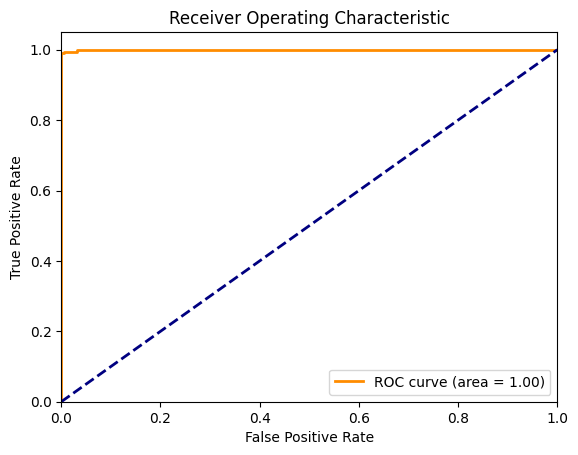

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict using the loaded model
y_pred = model.predict(X_test)

# Get the predicted probabilities for the positive class
y_pred_prob = y_pred[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


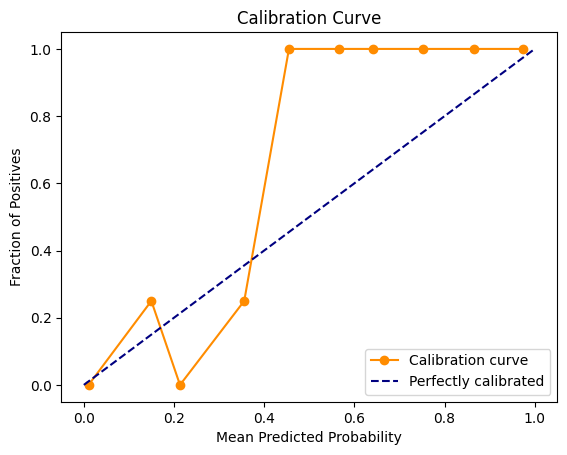

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve predicted probabilities of the positive class  with the actual observed frequencies of positive outcomes.
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate EER
#false accpetance and false rejection
eer_threshold = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer = 1. - interp1d(fpr, tpr)(eer_threshold)

print("Equal Error Rate (EER):", eer)

Equal Error Rate (EER): 0.00512820512820511
